# IMPORT DATASET

In [1]:
# Install kaggle dan kagglehub jika belum
!pip install -q kagglehub

import kagglehub

# Download dataset dari Kaggle (otomatis simpan ke cache)
path = kagglehub.dataset_download("aliefrahmanhakim/type-of-plastic-waste-dataset")
print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/type-of-plastic-waste-dataset


In [2]:
import os
import numpy as np
import random
import seaborn as sns
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt




# DATA LOAD

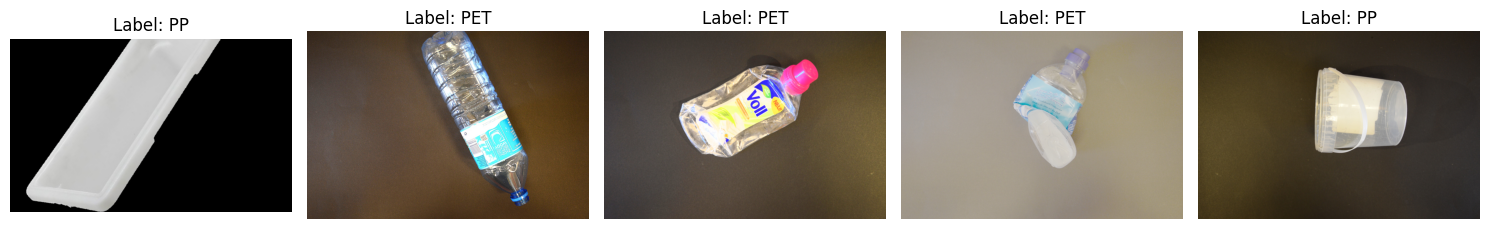

In [3]:


# Path utama dataset
df = "/root/.cache/kagglehub/datasets/aliefrahmanhakim/type-of-plastic-waste-dataset/versions/2"

# Cari semua file gambar (dengan path lengkap)
image_paths = []
for root, dirs, files in os.walk(df):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))

# Tentukan jumlah gambar yang ingin ditampilkan
num_images_to_display = 5
selected_images = random.sample(image_paths, min(num_images_to_display, len(image_paths)))

# Tampilkan gambar-gambar secara horizontal
plt.figure(figsize=(15, 5))

for i, image_path in enumerate(selected_images):
    img = Image.open(image_path)
    label = os.path.basename(os.path.dirname(image_path))

    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# DATA UNDERSTANDING

Total gambar dalam dataset: 14064


<ipython-input-4-8cc9fa7c44d6>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_counts, x="Label", y="Jumlah Gambar", palette="Set2")


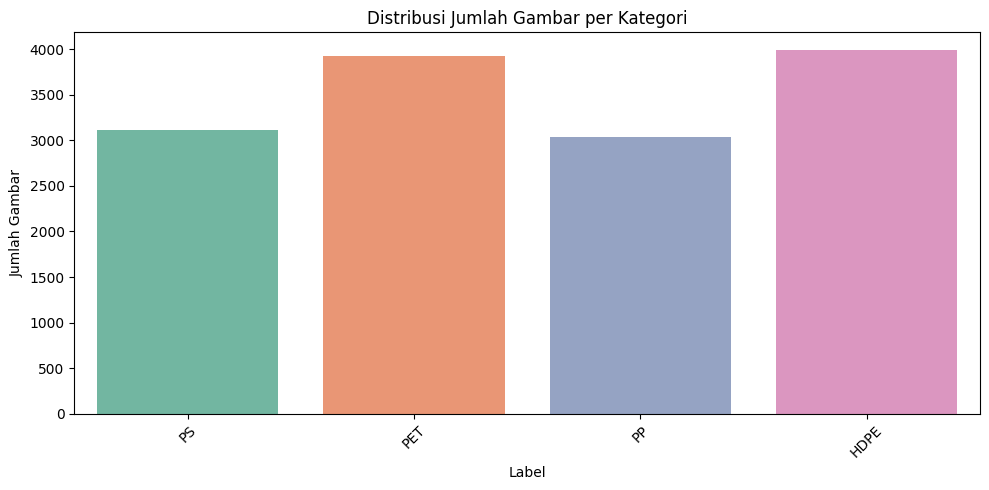

In [4]:


# Hitung jumlah gambar per kategori
category_counts = {}
total_images = 0  # variabel untuk menghitung total semua gambar

for root, dirs, files in os.walk(df):
    for file in files:
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            label = os.path.basename(root)  # ambil nama folder langsung berisi gambar
            category_counts[label] = category_counts.get(label, 0) + 1
            total_images += 1

# Konversi ke DataFrame
df_counts = pd.DataFrame(list(category_counts.items()), columns=["Label", "Jumlah Gambar"])

# Print total gambar keseluruhan
print(f"Total gambar dalam dataset: {total_images}")

# Visualisasi bar chart
plt.figure(figsize=(10, 5))
sns.barplot(data=df_counts, x="Label", y="Jumlah Gambar", palette="Set2")
plt.title("Distribusi Jumlah Gambar per Kategori")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


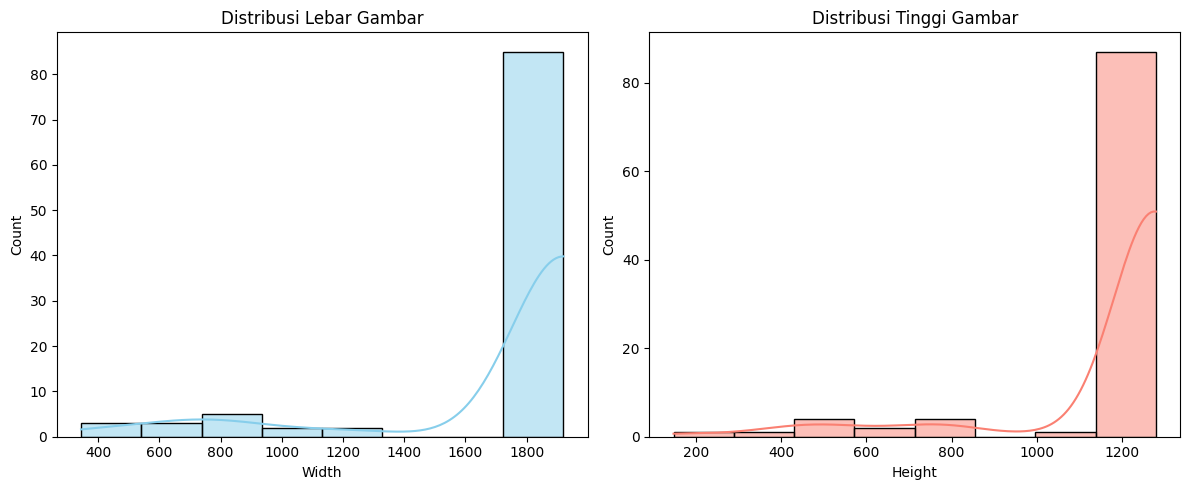

In [5]:
# Ambil beberapa ukuran gambar secara acak
image_sizes = []
sample_images = random.sample(image_paths, min(100, len(image_paths)))  # contoh 100 gambar

for img_path in sample_images:
    try:
        with Image.open(img_path) as img:
            image_sizes.append(img.size)  # (width, height)
    except:
        continue

# Konversi ke DataFrame
df_sizes = pd.DataFrame(image_sizes, columns=['Width', 'Height'])

# Visualisasi distribusi ukuran
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_sizes['Width'], kde=True, color='skyblue')
plt.title("Distribusi Lebar Gambar")

plt.subplot(1, 2, 2)
sns.histplot(df_sizes['Height'], kde=True, color='salmon')
plt.title("Distribusi Tinggi Gambar")

plt.tight_layout()
plt.show()


# DATA PREPROCESSING

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (128, 128)
batch_size = 32

train_dir = os.path.join(df, "train")
val_dir = os.path.join(df, "val")

# Generator untuk train dan val
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Flow dari direktori
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 11252 images belonging to 4 classes.
Found 2812 images belonging to 4 classes.


# MODELLING

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

# Bangun model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')  # Output layer sesuai jumlah kelas
])

# Kompilasi model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Latih model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator
)

# Visualisasi akurasi dan loss
plt.figure(figsize=(12, 4))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 670s 2s/step - accuracy: 0.3691 - loss: 1.2940 - val_accuracy: 0.6426 - val_loss: 0.8636
Epoch 2/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 649s 2s/step - accuracy: 0.6048 - loss: 0.9165 - val_accuracy: 0.6977 - val_loss: 0.7390
Epoch 3/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 647s 2s/step - accuracy: 0.6750 - loss: 0.7578 - val_accuracy: 0.7518 - val_loss: 0.5854
Epoch 4/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 650s 2s/step - accuracy: 0.7126 - loss: 0.6487 - val_accuracy: 0.7450 - val_loss: 0.5565
Epoch 5/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 638s 2s/step - accuracy: 0.7212 - loss: 0.6229 - val_accuracy: 0.7955 - val_loss: 0.4828
Epoch 6/15
352/352 ━━━━━━━━━━━━━━━━━━━━ 643s 2s/step - accuracy: 0.7444 - loss: 0.5712 - val_accuracy: 0.7664 - val_loss: 0.6186
Epoch 7/15
133/352 ━━━━━━━━━━━━━━━━━━━━ 6:00 2s/step - accuracy: 0.7770 - loss: 0.5258